<a href="https://colab.research.google.com/github/fralfaro/MAT306/blob/main/docs/labs/lab_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT306 - Laboratorio N°08

**Objetivo**: Aplicar técnicas de **machine learning no supervisado** para explorar, procesar y analizar conjuntos de datos con variables numéricas y categóricas.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


## Clustering


<img src="https://www.svgrepo.com/show/253022/car.svg" width = "300" align="center"/>



El conjunto de datos **`vehiculos_procesado_con_grupos.csv`** recopila información sobre diversas características relevantes de distintos vehículos. El propósito de este ejercicio es **clasificar los vehículos en diferentes categorías**, utilizando como base las variables descritas en la tabla de atributos.

El análisis presenta un desafío adicional debido a la **naturaleza mixta de los datos**: se incluyen tanto variables **numéricas** (ej. dimensiones, consumo, emisiones) como **categóricas** (ej. tipo de tracción, tipo de combustible), lo que requiere aplicar técnicas de preprocesamiento adecuadas antes de entrenar los modelos.

Como primer paso, procederemos a **cargar y explorar el conjunto de datos**, con el fin de familiarizarnos con su estructura y las características que servirán como base para la posterior clasificación.




**Descripción de los Datos:**

| **Nombre de la Columna**   | **Descripción**                                                                                                                                   |
|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| **year**                   | El año en que el vehículo fue fabricado.                                                                                                          |
| **desplazamiento**          | La capacidad volumétrica del motor en litros. Indica la cantidad de aire y combustible que puede desplazar el motor durante una revolución.       |
| **cilindros**               | El número de cilindros que tiene el motor. Los cilindros son las cámaras donde ocurre la combustión interna en los motores de los vehículos.       |
| **co2**                     | Emisiones de dióxido de carbono del vehículo, medido en gramos por kilómetro. Es una medida de las emisiones de gases de efecto invernadero.       |
| **clase_tipo**              | La clase o tipo de vehículo, como vehículos especiales, deportivos, etc.                                                                         |
| **traccion_tipo**           | Tipo de tracción del vehículo, ya sea tracción en dos ruedas, en cuatro ruedas o en todas las ruedas.                                             |
| **transmision_tipo**        | Tipo de transmisión del vehículo, como automática, manual, entre otros.                                                                          |
| **combustible_tipo**        | Tipo de combustible que utiliza el vehículo, como gasolina, diésel, eléctrico, híbrido, etc.                                                     |
| **tamano_motor_tipo**       | Clasificación del tamaño del motor (por ejemplo, pequeño, mediano o grande), que generalmente se basa en la capacidad de desplazamiento.           |
| **consumo_tipo**            | Clasificación del nivel de consumo de combustible del vehículo, indicando si es alto, bajo, o muy alto.                                           |
| **co2_tipo**                | Clasificación de las emisiones de CO2 del vehículo, indicando si es alto, bajo, o muy alto.                                                       |
| **consumo_litros_milla**    | El consumo de combustible del vehículo, medido en litros por milla. Indica la eficiencia del vehículo en términos de consumo de combustible.        |



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans


%matplotlib inline

sns.set_palette("deep", desat=.6)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
# cargar datos
df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT306/main/docs/labs/data/vehiculos_procesado_con_grupos.csv", sep=",")\
       .drop(
            ["fabricante",
             "modelo",
             "transmision",
             "traccion",
             "clase",
             "combustible",
             "consumo"],

          axis=1)

df.head()

,year,desplazamiento,cilindros,co2,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo,consumo_litros_milla
0,1984,2.5,4.0,522.764706,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.222671
1,1984,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
2,1985,2.5,4.0,555.437500,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.236588
3,1985,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
4,1987,3.8,6.0,555.437500,Coches Medianos,dos,Automatica,Premium,grande,alto,alto,0.236588


En este caso, no solo se tienen datos numéricos, sino que también categóricos. Además, tenemos problemas de datos **vacíos (Nan)**. Así que para resolver este problema, seguiremos varios pasos:

### 1.- Normalizar datos

- Cree un conjunto de datos con las variables numéricas, además, para cada dato vacía, rellene con el promedio asociado a esa columna. Finalmente, normalize los datos mediante el procesamiento **MinMaxScaler** de **sklearn**.
- Cree un conjunto de datos con las variables categóricas , además, transforme de variables categoricas a numericas ocupando el comando **get_dummies** de pandas ([referencia](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)). Explique a grande rasgo como se realiza la codificación de variables numéricas a categóricas.

- Junte ambos dataset en uno, llamado **df_procesado**.

**SOLUCIÓN**

In [4]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

df_numeric = df[numeric_cols].copy()
df_categorical = df[categorical_cols].copy()

Ahora, para los datos numéricos, procederemos a rellenar los datos vacíos con el promedios de la columna, posteriormente normalizamos con MinMaxScaler

In [8]:
# Rellenar valores NaN con el promedio de cada columna
for col in df_numeric.columns:
    if df_numeric[col].isnull().sum() > 0:
        mean_val = df_numeric[col].mean()
        df_numeric[col].fillna(mean_val, inplace=True)

scaler = MinMaxScaler()
df_numeric_scaled = pd.DataFrame(
    scaler.fit_transform(df_numeric),
    columns=df_numeric.columns,
    index=df_numeric.index
)

Ahora, para las variables categóricas, rellenaremos los valores NaN con 'Desconocido' y posteriormente aplciaremos get_dummies, la cual transforma variables categóricas en columnas binarias (0/1), una por cada categoría existente.

In [10]:
df_categorical.fillna('Desconocido', inplace=True)
df_categorical_encoded = pd.get_dummies(df_categorical, prefix_sep='_')

In [11]:
df_procesado = pd.concat([df_numeric_scaled, df_categorical_encoded], axis=1)


### 2.- Realizar ajuste mediante kmeans

Una vez depurado el conjunto de datos, es momento de aplicar el algoritmo de **kmeans**.

1. Ajuste el modelo de **kmeans** sobre el conjunto de datos, con un total de **8 clusters**.
2. Asociar a cada individuo el correspondiente cluster y calcular valor de los centroides de cada cluster.
3. Realizar un resumen de las principales cualidades de cada cluster. Para  esto debe calcular (para cluster) las siguientes medidas de resumen:
    * Valor promedio de las variables numérica
    * Moda para las variables numericas

In [13]:
kmeans_modelo = KMeans(n_clusters=8, random_state=42, n_init=10)
asignacion_clusters = kmeans_modelo.fit_predict(df_procesado)

In [14]:
df_procesado['cluster_asignado'] = asignacion_clusters
df_original = df.copy()
df_original['cluster_asignado'] = asignacion_clusters

for columna in numeric_cols:
    df_original[columna].fillna(df_original[columna].mean(), inplace=True)
for columna in categorical_cols:
    df_original[columna].fillna('Desconocido', inplace=True)

centroides_clusters = kmeans_modelo.cluster_centers_

C:\Users\carlo\AppData\Local\Temp\ipykernel_16836\3311901383.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_original[columna].fillna(df_original[columna].mean(), inplace=True)
C:\Users\carlo\AppData\Local\Temp\ipykernel_16836\3311901383.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [15]:
resumen_clusters = []
for numero_cluster in range(8):
    datos_cluster = df_original[df_original['cluster_asignado'] == numero_cluster]
    
    promedios_numericos = datos_cluster[numeric_cols].mean()
    
    modas_categoricas = {}
    for columna in categorical_cols:
        moda_serie = datos_cluster[columna].mode()
        modas_categoricas[columna] = moda_serie[0] if len(moda_serie) > 0 else 'No disponible'
    
    caracteristicas_cluster = {
        'numero_cluster': numero_cluster,
        'total_vehiculos': len(datos_cluster),
        'ano_promedio': promedios_numericos['year'],
        'emisiones_co2_promedio': promedios_numericos['co2'],
        'consumo_promedio': promedios_numericos['consumo_litros_milla'],
        'cilindros_promedio': promedios_numericos['cilindros'],
        'desplazamiento_promedio': promedios_numericos['desplazamiento'],
        'tipo_vehiculo_mas_comun': modas_categoricas['clase_tipo'],
        'combustible_mas_comun': modas_categoricas['combustible_tipo'],
        'tamano_motor_mas_comun': modas_categoricas['tamano_motor_tipo'],
        'traccion_mas_comun': modas_categoricas['traccion_tipo'],
        'transmision_mas_comun': modas_categoricas['transmision_tipo']
    }
    
    resumen_clusters.append(caracteristicas_cluster)

df_resumen_final = pd.DataFrame(resumen_clusters)

In [16]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
df_resumen_final

,numero_cluster,total_vehiculos,ano_promedio,emisiones_co2_promedio,consumo_promedio,cilindros_promedio,desplazamiento_promedio,tipo_vehiculo_mas_comun,combustible_mas_comun,tamano_motor_mas_comun,traccion_mas_comun,transmision_mas_comun
0,0,2687,1998.516561,406.901026,0.172938,4.431242,2.345821,Coches pequeños,Normal,pequeño,dos,Manual
1,1,7127,1998.011225,657.853399,0.279076,7.882138,5.093854,Camionetas,Normal,muy grande,dos,Automatica
2,2,4811,2003.627728,407.750832,0.173122,4.948867,2.711515,Coches pequeños,Normal,pequeño,dos,Automatica
3,3,3843,2007.622691,326.781547,0.139767,4.108509,1.997606,Coches pequeños,Normal,muy pequeño,dos,Automatica
4,4,3589,1998.909167,329.463017,0.139661,3.975967,1.843807,Coches pequeños,Normal,muy pequeño,dos,Manual
5,5,6057,1997.858346,468.522648,0.199432,5.595798,3.185240,Coches pequeños,Normal,mediano,dos,Automatica
6,6,4690,2000.267591,537.751723,0.228516,6.584435,4.118017,Camionetas,Normal,grande,dos,Automatica
7,7,3987,2004.016805,468.330734,0.199476,6.193629,3.425859,Coches pequeños,Premium,mediano,dos,Automatica


### 3.- Elegir Número de cluster

Estime mediante la **regla del codo**, el número de cluster apropiados para el caso.
Para efectos prácticos, eliga la siguiente secuencia como número de clusters a comparar:

$$[5, 10, 20, 30, 50, 75, 100, 200, 300]$$

Una vez realizado el gráfico, saque sus propias conclusiones del caso.

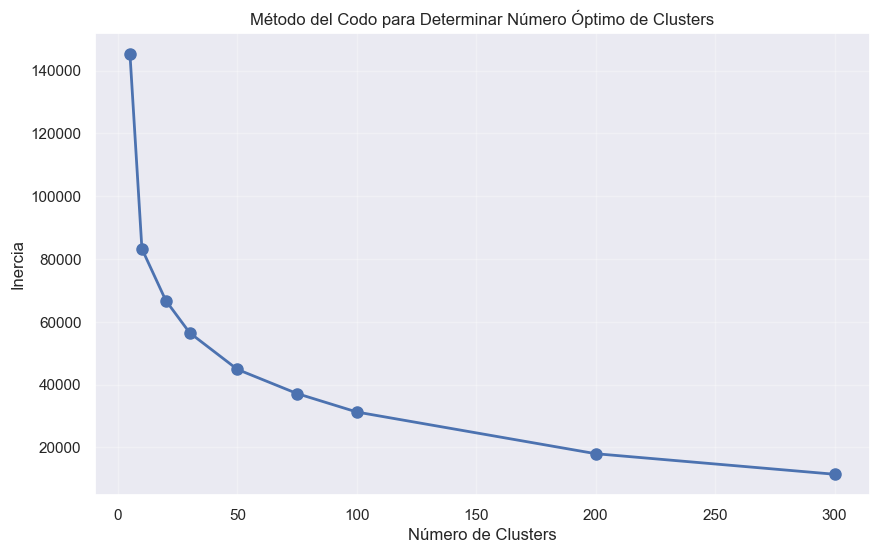

In [17]:
numeros_clusters = [5, 10, 20, 30, 50, 75, 100, 200, 300]
inercia_valores = []

for k in numeros_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_procesado)
    inercia_valores.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(numeros_clusters, inercia_valores, 'bo-', markersize=8, linewidth=2)
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar Número Óptimo de Clusters')
plt.grid(True, alpha=0.3)
plt.show()

Al observar el gráfico resultante, se pueden obtener conclusiones sobre el número apropiado de clusters. La regla del codo sugiere elegir el número de clusters donde la reducción en la inercia se estabiliza significativamente. En otras palabras, se busca el punto en el gráfico donde la curva de inercia comienza a aplanarse o forma un codo.

**Respuesta** Aunque el gráfico no presenta un aplanamiento marcado, se observa un cambio significativo en la pendiente alrededor de 20-30 clusters, donde la reducción de inercia comienza a ser menos abrupta. Para clusters superiores a 30, las reducciones absolutas (∼10000 unidades) siguen siendo considerables, pero en términos relativos representan ganancias marginales decrecientes (ej: 5-10% sobre inercia inicial alta), lo que no justifica la complejidad adicional. Por ello, el rango de 20-30 clusters se considera el punto de codo óptimo para este caso.

## Reducción de Dimensionalidad

<img src="https://1000logos.net/wp-content/uploads/2020/11/Wine-Logo-old.png" width = "300" align="center"/>


Para este ejercicio utilizaremos el **Wine Dataset**, un conjunto de datos clásico disponible en la librería **scikit-learn** y en el repositorio de la **UCI Machine Learning**.
Este dataset contiene información de **178 muestras de vino** provenientes de la región italiana de *Piamonte*. Cada vino pertenece a una de **tres variedades de uva** (*clases*), que actúan como etiquetas para el análisis supervisado, pero aquí se usarán solo como referencia en la visualización.

Cada muestra está descrita por **13 variables químicas** obtenidas de un análisis de laboratorio, entre ellas:

* **Alcohol**: porcentaje de alcohol en el vino.
* **Malic acid**: concentración de ácido málico.
* **Ash**: contenido de ceniza.
* **Alcalinity of ash**: alcalinidad de la ceniza.
* **Magnesium**: cantidad de magnesio (mg/L).
* **Total phenols**: concentración total de fenoles.
* **Flavanoids**: tipo de fenoles con propiedades antioxidantes.
* **Nonflavanoid phenols**: fenoles que no son flavonoides.
* **Proanthocyanins**: compuestos relacionados con el color y el sabor.
* **Color intensity**: intensidad del color del vino.
* **Hue**: matiz del color.
* **OD280/OD315 of diluted wines**: relación de absorbancia que mide la calidad del vino.
* **Proline**: concentración de prolina (un aminoácido).

Estas características permiten representar cada vino como un punto en un espacio de **13 dimensiones**.

El objetivo del análisis con este dataset es **reducir la dimensionalidad** para visualizar y explorar patrones en los datos. Para ello aplicaremos:

* **PCA (Principal Component Analysis):** identificar las combinaciones lineales de variables que explican la mayor varianza en el conjunto.
* **t-SNE (t-distributed Stochastic Neighbor Embedding):** mapear las muestras a 2D o 3D, preservando relaciones de vecindad y estructuras no lineales.

La comparación entre ambas técnicas permitirá observar cómo las tres clases de vinos se diferencian en el espacio reducido y discutir la utilidad de la reducción de dimensionalidad en datos con mayor número de variables que en el caso del dataset *Wine*.



In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [23]:
# cargar dataset
dataset = load_wine()

# nombres de las variables
features = dataset.feature_names
target = 'wine_class'

# construir DataFrame
wine = pd.DataFrame(dataset.data, columns=features)
wine[target] = dataset.target

# ver primeras filas
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0




### 1. **Análisis detallado con PCA**

* Calcular la **varianza explicada** por cada componente principal y representar el gráfico de varianza acumulada, identificando cuántos componentes son necesarios para capturar al menos el **90–95% de la información**.
* Construir tablas y gráficos que muestren cómo las observaciones (vinos) se proyectan en las primeras componentes principales.
* Analizar los **loadings** (coeficientes de cada variable en los componentes) e interpretar qué características químicas del vino (alcohol, fenoles, color, etc.) tienen mayor influencia en las nuevas dimensiones.
* Visualizar los datos reducidos a 2D o 3D e interpretar si las **tres variedades de vino** se separan de forma clara en el espacio proyectado.



In [ ]:
scaler = StandardScaler()
wine_scaled = scaler.fit_transform(wine[features])

pca = PCA()
pca_result = pca.fit_transform(wine_scaled)

varianza_explicada = pca.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)

varianza_df = pd.DataFrame({
    'Componente': range(1, len(varianza_explicada) + 1),
    'Varianza_Explicada': varianza_explicada,
    'Varianza_Acumulada': varianza_acumulada
})

ANÁLISIS DE VARIANZA EXPLICADA POR COMPONENTE

   Componente  Varianza_Explicada  Varianza_Acumulada
0           1            0.361988            0.361988
1           2            0.192075            0.554063
2           3            0.111236            0.665300
3           4            0.070690            0.735990
4           5            0.065633            0.801623
5           6            0.049358            0.850981
6           7            0.042387            0.893368
7           8            0.026807            0.920175
8           9            0.022222            0.942397
9          10            0.019300            0.961697


In [25]:
componentes_90 = np.argmax(varianza_acumulada >= 0.90) + 1
componentes_95 = np.argmax(varianza_acumulada >= 0.95) + 1

print(f"Componentes para 90% de varianza: {componentes_90}")
print(f"Componentes para 95% de varianza: {componentes_95}")

Componentes para 90% de varianza: 8
Componentes para 95% de varianza: 10


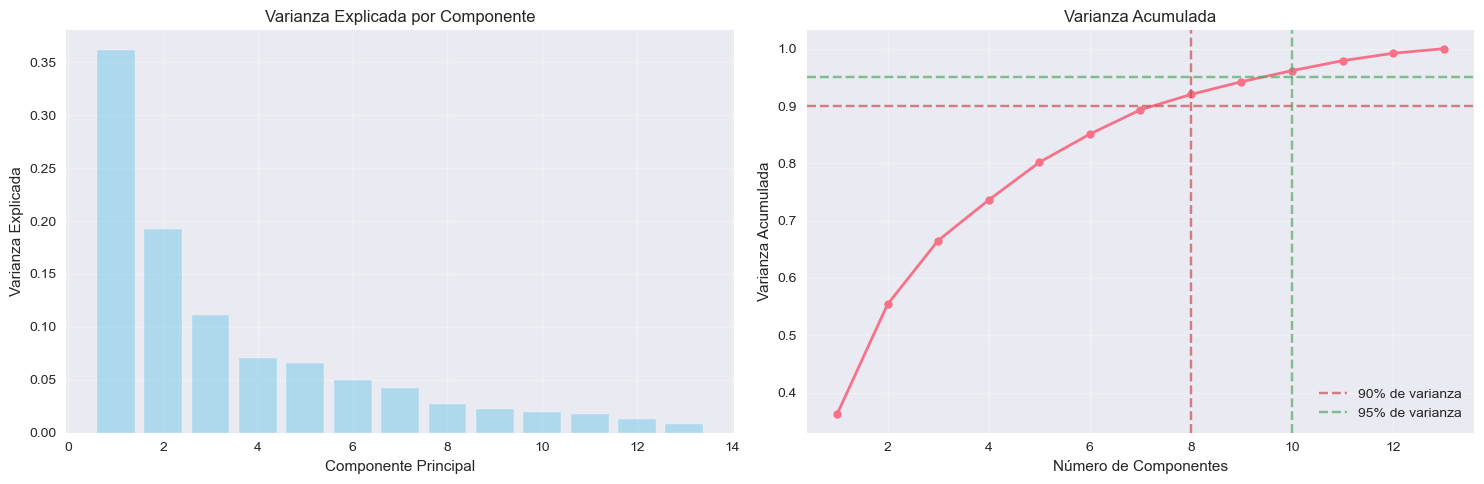

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(range(1, len(varianza_explicada) + 1), varianza_explicada, alpha=0.6, color='skyblue')
ax1.set_xlabel('Componente Principal')
ax1.set_ylabel('Varianza Explicada')
ax1.set_title('Varianza Explicada por Componente')
ax1.grid(True, alpha=0.3)

ax2.plot(range(1, len(varianza_acumulada) + 1), varianza_acumulada, 'o-', linewidth=2, markersize=6)
ax2.axhline(y=0.90, color='r', linestyle='--', alpha=0.7, label='90% de varianza')
ax2.axhline(y=0.95, color='g', linestyle='--', alpha=0.7, label='95% de varianza')
ax2.axvline(x=componentes_90, color='r', linestyle='--', alpha=0.7)
ax2.axvline(x=componentes_95, color='g', linestyle='--', alpha=0.7)
ax2.set_xlabel('Número de Componentes')
ax2.set_ylabel('Varianza Acumulada')
ax2.set_title('Varianza Acumulada')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [44]:
pca_2d = PCA(n_components=2)
wine_pca_2d = pca_2d.fit_transform(wine_scaled)

pca_df = pd.DataFrame(data=wine_pca_2d, columns=['PC1', 'PC2'])
pca_df['Wine_Class'] = wine[target]
pca_df['Wine_Name'] = pca_df['Wine_Class'].map({0: 'Class_0', 1: 'Class_1', 2: 'Class_2'})

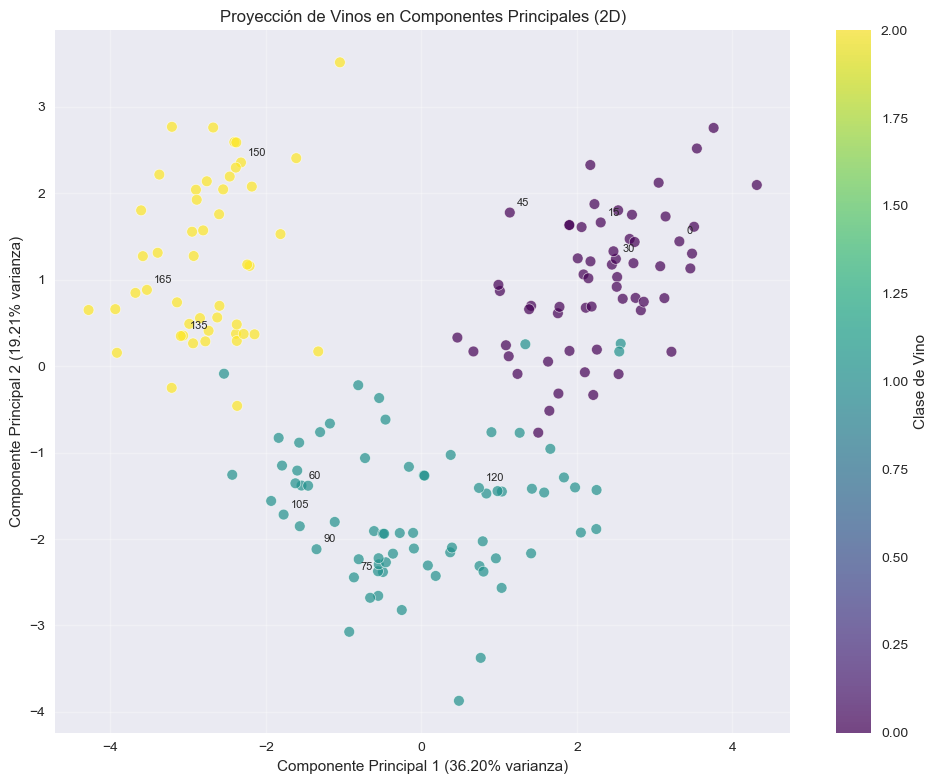

In [45]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], 
                     c=pca_df['Wine_Class'], cmap='viridis', 
                     s=60, alpha=0.7, edgecolors='w', linewidth=0.5)

plt.xlabel(f'Componente Principal 1 ({pca_2d.explained_variance_ratio_[0]:.2%} varianza)')
plt.ylabel(f'Componente Principal 2 ({pca_2d.explained_variance_ratio_[1]:.2%} varianza)')
plt.title('Proyección de Vinos en Componentes Principales (2D)')
plt.colorbar(scatter, label='Clase de Vino')
plt.grid(True, alpha=0.3)

for i in range(0, len(pca_df), 15):
    plt.annotate(str(i), (pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i]), 
                 xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

In [33]:
loadings = pca_2d.components_.T
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=features)

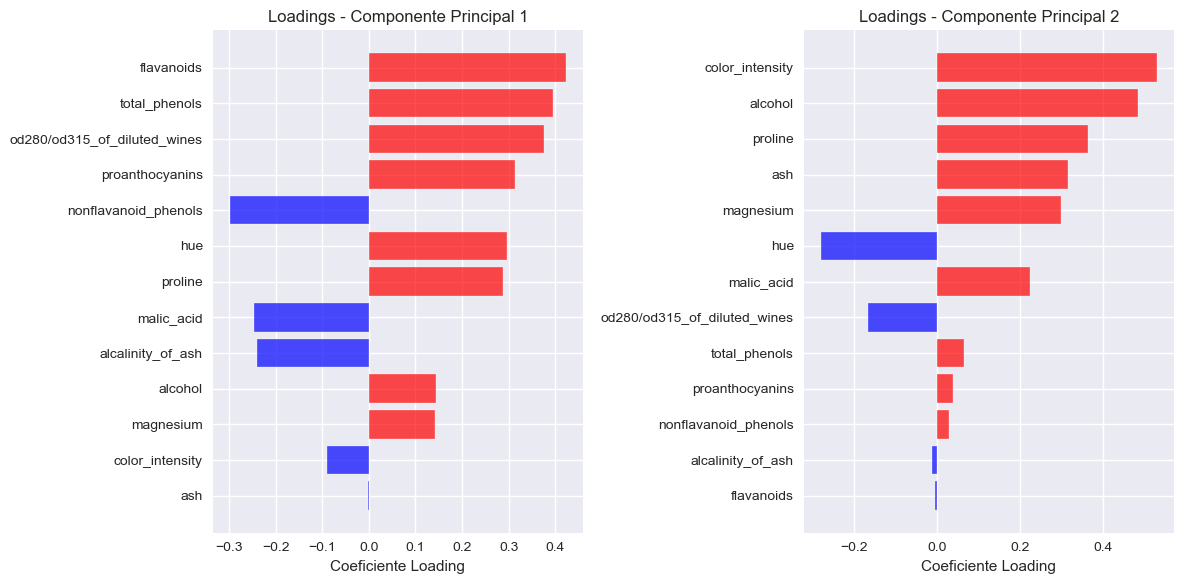

In [34]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sorted_loadings_pc1 = loadings_df.sort_values('PC1', key=abs, ascending=False)
colors_pc1 = ['red' if x > 0 else 'blue' for x in sorted_loadings_pc1['PC1']]
plt.barh(sorted_loadings_pc1.index, sorted_loadings_pc1['PC1'], color=colors_pc1, alpha=0.7)
plt.xlabel('Coeficiente Loading')
plt.title('Loadings - Componente Principal 1')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
sorted_loadings_pc2 = loadings_df.sort_values('PC2', key=abs, ascending=False)
colors_pc2 = ['red' if x > 0 else 'blue' for x in sorted_loadings_pc2['PC2']]
plt.barh(sorted_loadings_pc2.index, sorted_loadings_pc2['PC2'], color=colors_pc2, alpha=0.7)
plt.xlabel('Coeficiente Loading')
plt.title('Loadings - Componente Principal 2')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

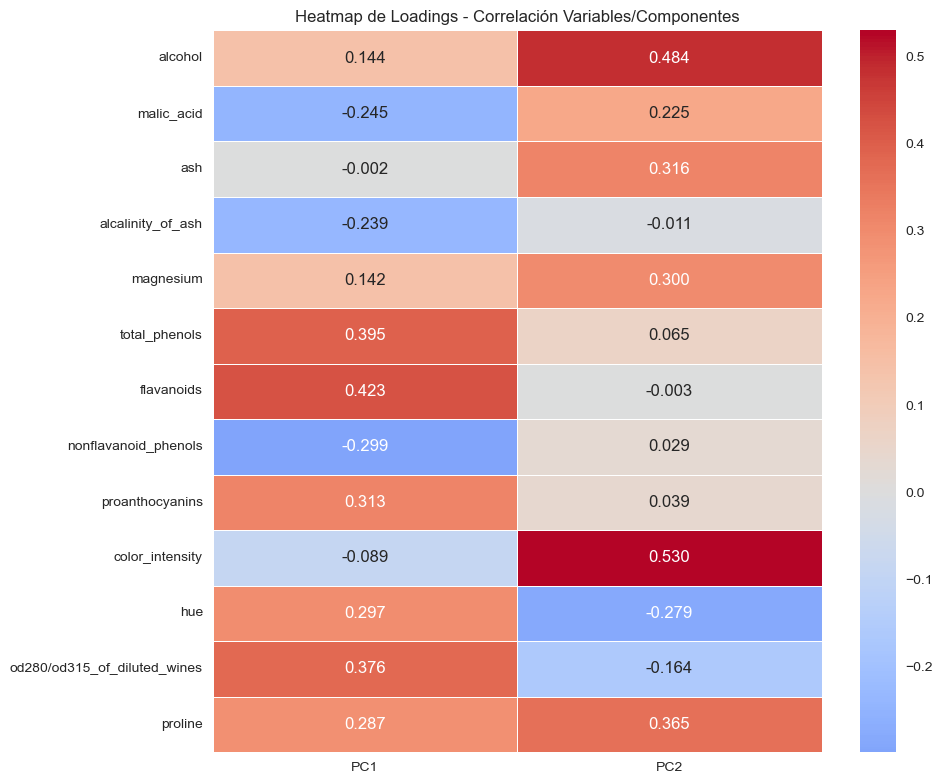

In [35]:
plt.figure(figsize=(10, 8))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', linewidths=0.5)
plt.title('Heatmap de Loadings - Correlación Variables/Componentes')
plt.tight_layout()
plt.show()

Primero es importante mencionar que para capturar el 90-95% de la información, se necesitan más que 2 componentes. Según los resultados de varianza, se necesitan 10 componentes para explicar el 95% de la varianza. Luego, la proyección de vino en los 3 componentes principales indican que no hay una superposición significativa pudiendo hacer una separación en el espacio de las clases de vino. Luego, los loading indican que la primera componente esta medianamente correlacionada con atributos fenólicos, mientras que la segunda componente esta correlacioada con intensidad de color, prolina y alcohol.



### 2. **Análisis detallado con t-SNE**

* Aplicar **t-SNE** para reducir los datos a 2 dimensiones, probando diferentes configuraciones de hiperparámetros como *perplexity* y *learning rate*.
* Comparar las distintas visualizaciones obtenidas y discutir cómo los hiperparámetros afectan la estructura de los clústeres.
* Analizar si las **tres clases de vinos** forman agrupaciones definidas y si t-SNE logra capturar relaciones no lineales que PCA no refleja.



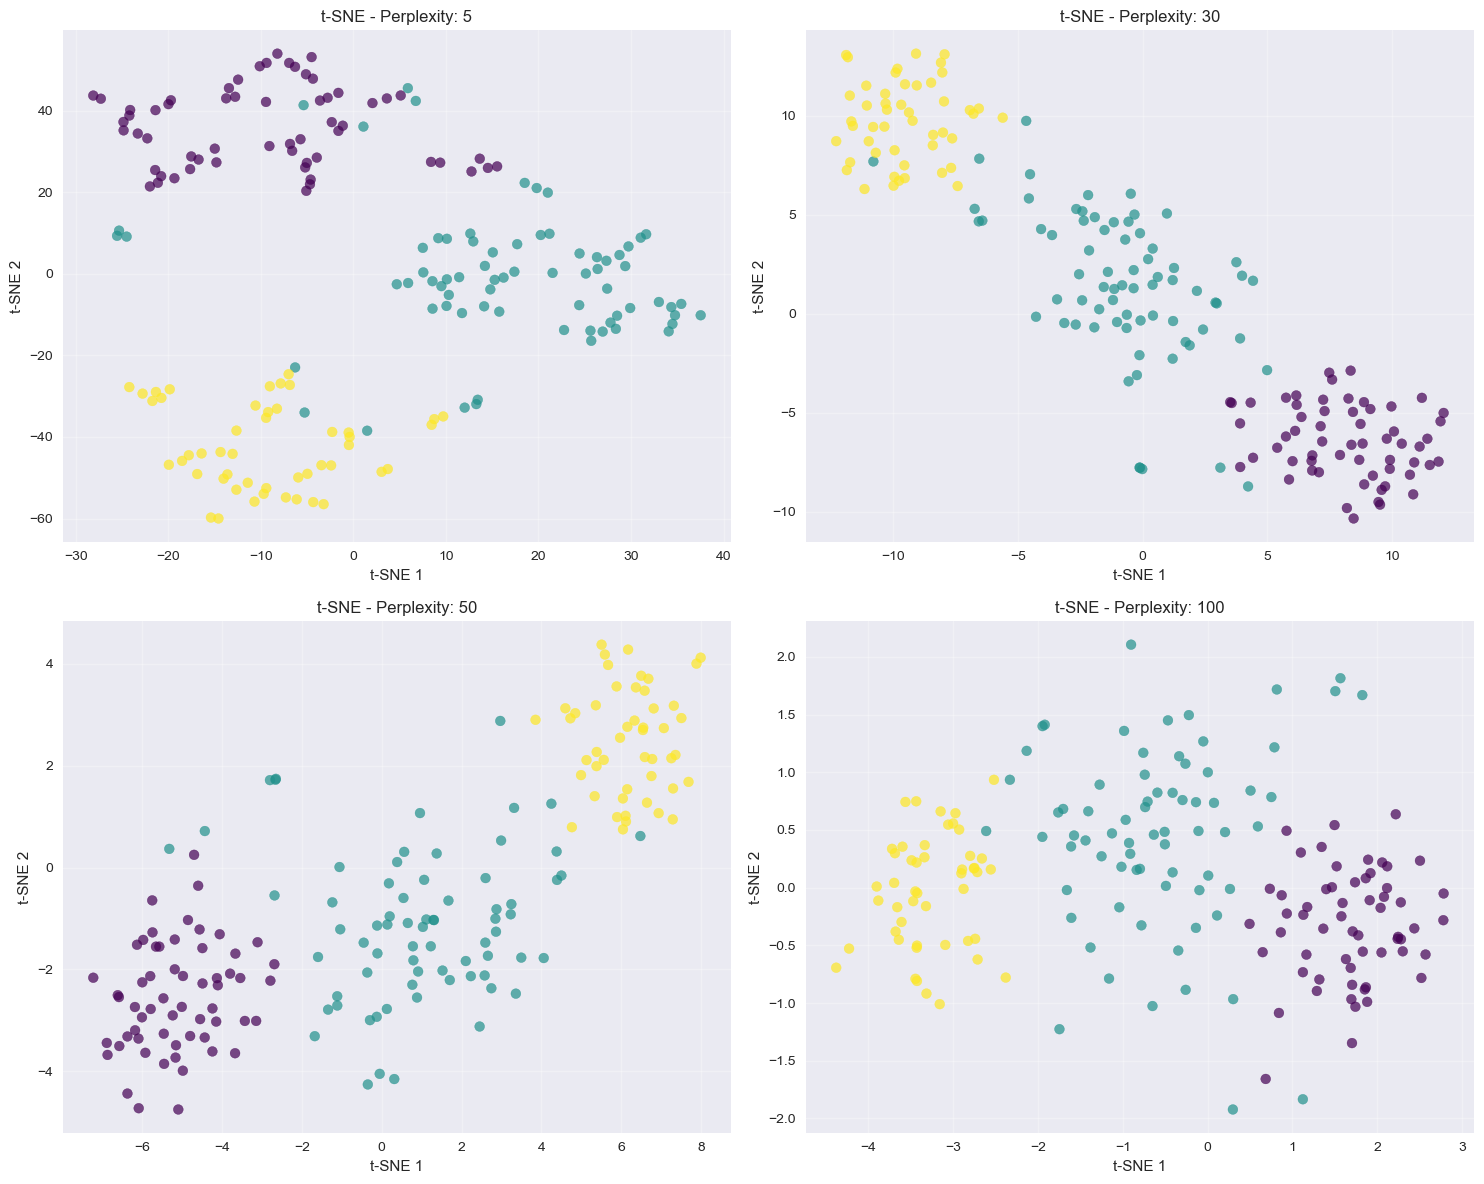

In [ ]:
perplexity_valores = [5, 30, 50, 100]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, perplexity in enumerate(perplexity_valores):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    wine_tsne = tsne.fit_transform(wine_scaled)
    
    scatter = axes[i].scatter(wine_tsne[:, 0], wine_tsne[:, 1], 
                             c=wine[target], cmap='viridis', s=50, alpha=0.7)
    axes[i].set_title(f't-SNE - Perplexity: {perplexity}')
    axes[i].set_xlabel('t-SNE 1')
    axes[i].set_ylabel('t-SNE 2')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

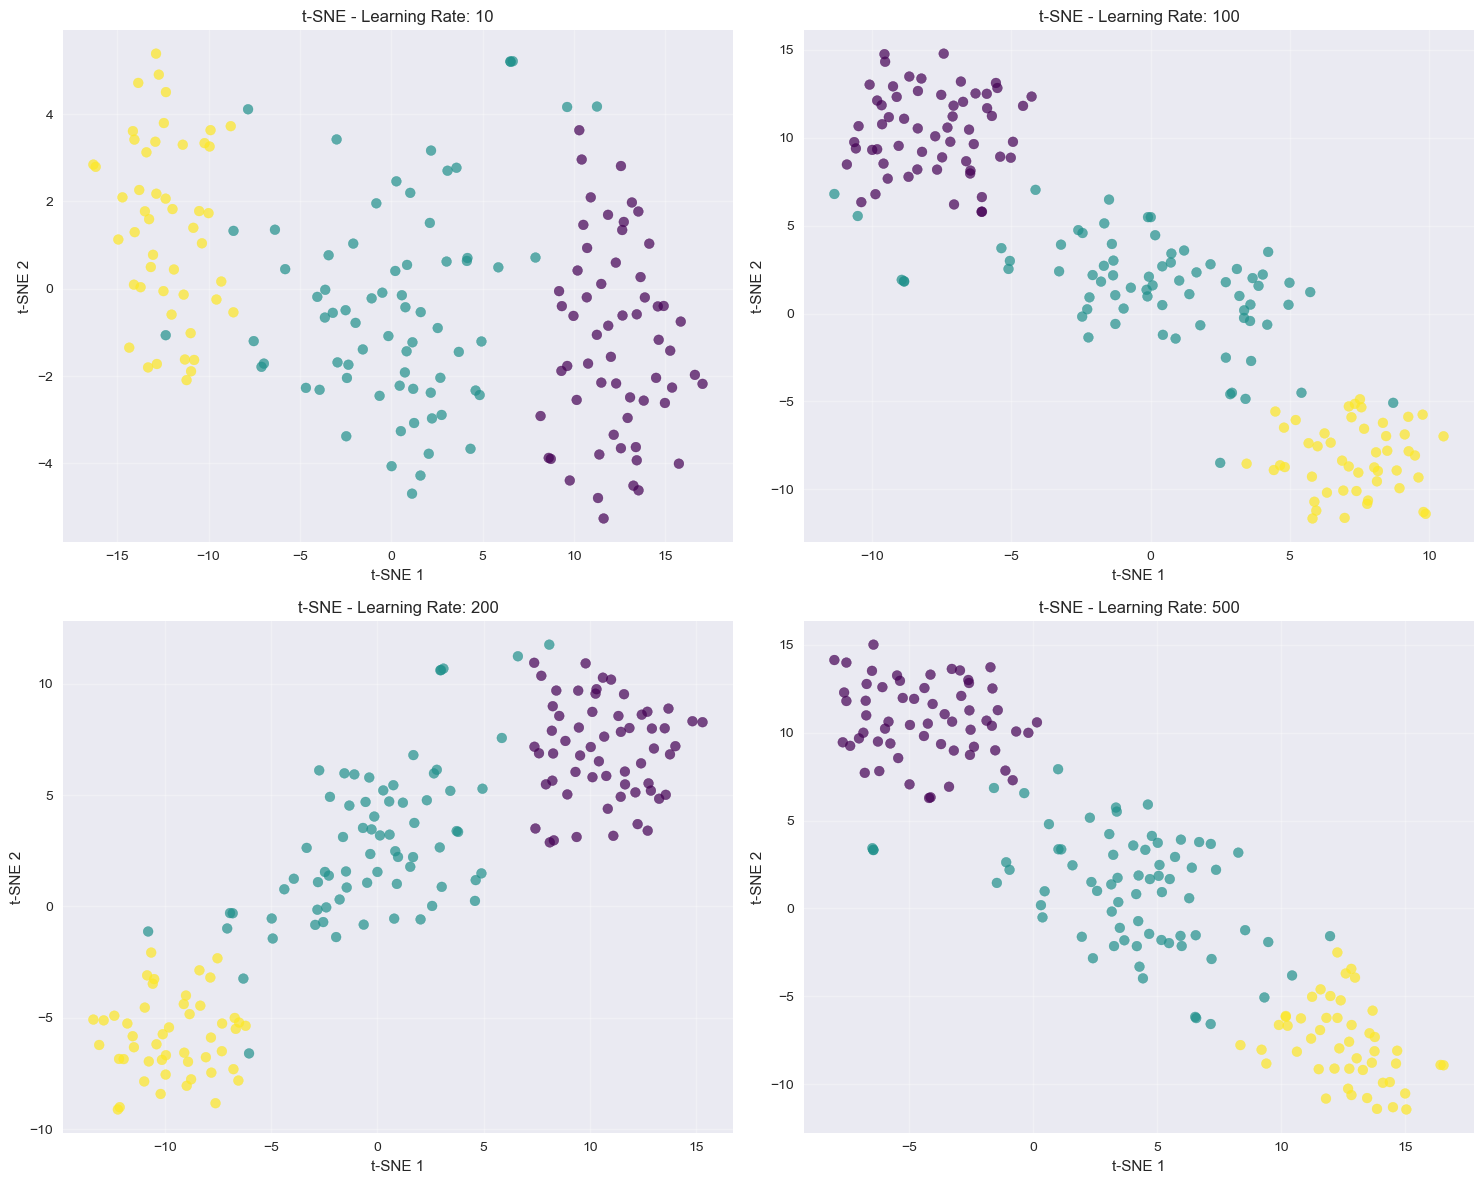

In [ ]:
learning_rates = [10, 100, 200, 500]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, lr in enumerate(learning_rates):
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=lr, random_state=42)
    wine_tsne = tsne.fit_transform(wine_scaled)
    
    scatter = axes[i].scatter(wine_tsne[:, 0], wine_tsne[:, 1], 
                             c=wine[target], cmap='viridis', s=50, alpha=0.7)
    axes[i].set_title(f't-SNE - Learning Rate: {lr}')
    axes[i].set_xlabel('t-SNE 1')
    axes[i].set_ylabel('t-SNE 2')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
tsne_optimo = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
wine_tsne_optimo = tsne_optimo.fit_transform(wine_scaled)

tsne_df = pd.DataFrame(data=wine_tsne_optimo, columns=['t-SNE1', 't-SNE2'])
tsne_df['Wine_Class'] = wine[target]
tsne_df['Wine_Name'] = tsne_df['Wine_Class'].map({0: 'Class_0', 1: 'Class_1', 2: 'Class_2'})

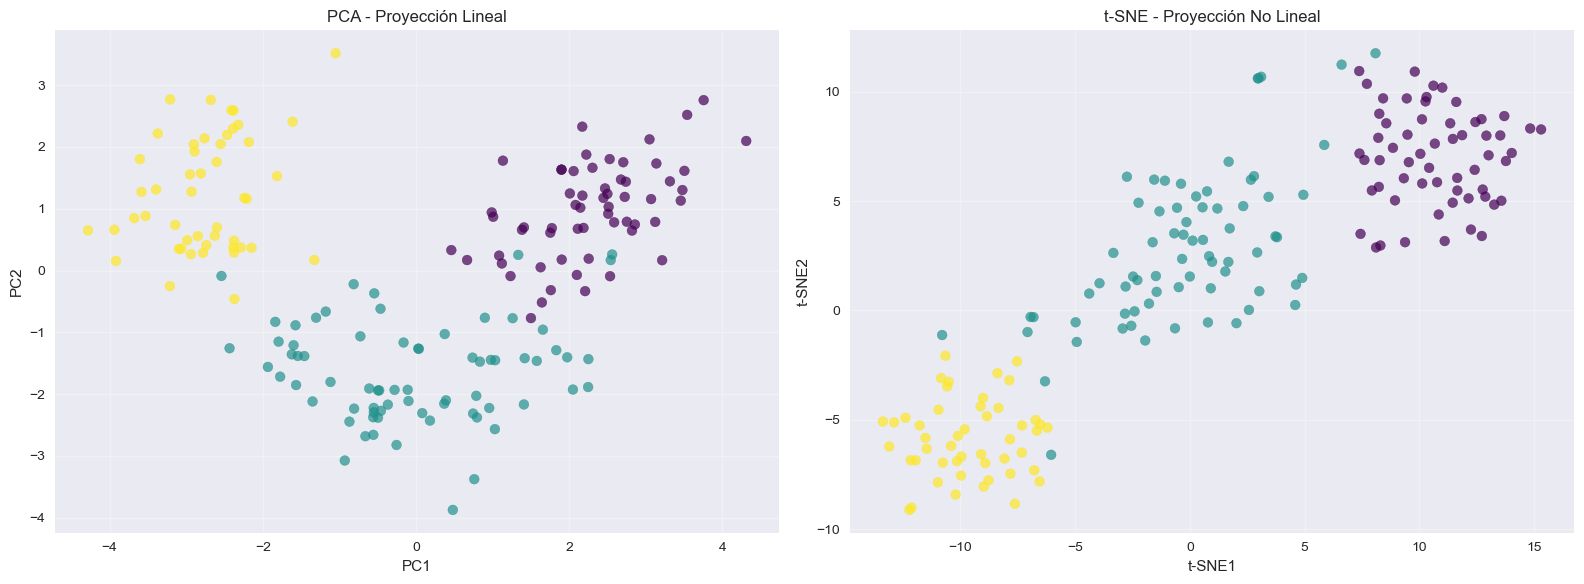

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = ax1.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Wine_Class'], 
                      cmap='viridis', s=50, alpha=0.7)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('PCA - Proyección Lineal')
ax1.grid(True, alpha=0.3)

scatter2 = ax2.scatter(tsne_df['t-SNE1'], tsne_df['t-SNE2'], c=tsne_df['Wine_Class'], 
                      cmap='viridis', s=50, alpha=0.7)
ax2.set_xlabel('t-SNE1')
ax2.set_ylabel('t-SNE2')
ax2.set_title('t-SNE - Proyección No Lineal')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_pca = silhouette_score(pca_df[['PC1', 'PC2']], pca_df['Wine_Class'])
silhouette_tsne = silhouette_score(tsne_df[['t-SNE1', 't-SNE2']], tsne_df['Wine_Class'])

print("COMPARACIÓN PCA vs t-SNE")
print(f"Silhouette Score PCA: {silhouette_pca:.3f}")
print(f"Silhouette Score t-SNE: {silhouette_tsne:.3f}")

=== COMPARACIÓN PCA vs t-SNE ===
Silhouette Score PCA: 0.526
Silhouette Score t-SNE: 0.557


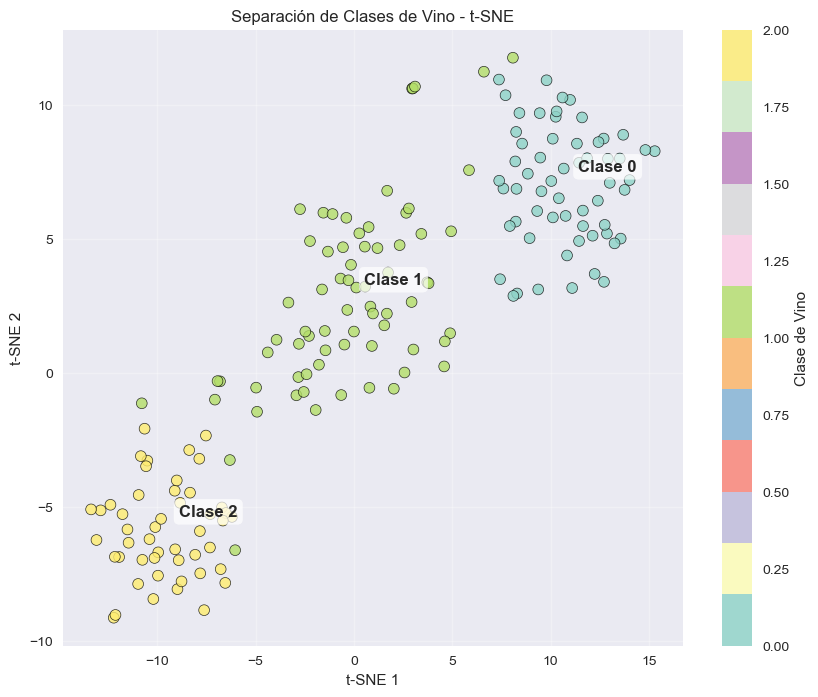

In [41]:
# Visualización de la separación de clases en t-SNE con etiquetas
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_df['t-SNE1'], tsne_df['t-SNE2'], 
                     c=tsne_df['Wine_Class'], cmap='Set3', 
                     s=60, alpha=0.8, edgecolors='black', linewidth=0.5)

# Etiquetar algunos puntos representativos
for class_id in range(3):
    class_data = tsne_df[tsne_df['Wine_Class'] == class_id]
    centroid_x = class_data['t-SNE1'].mean()
    centroid_y = class_data['t-SNE2'].mean()
    plt.annotate(f'Clase {class_id}', (centroid_x, centroid_y), 
                 xytext=(10, 10), textcoords='offset points',
                 fontsize=12, fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Separación de Clases de Vino - t-SNE')
plt.colorbar(scatter, label='Clase de Vino')
plt.grid(True, alpha=0.3)
plt.show()

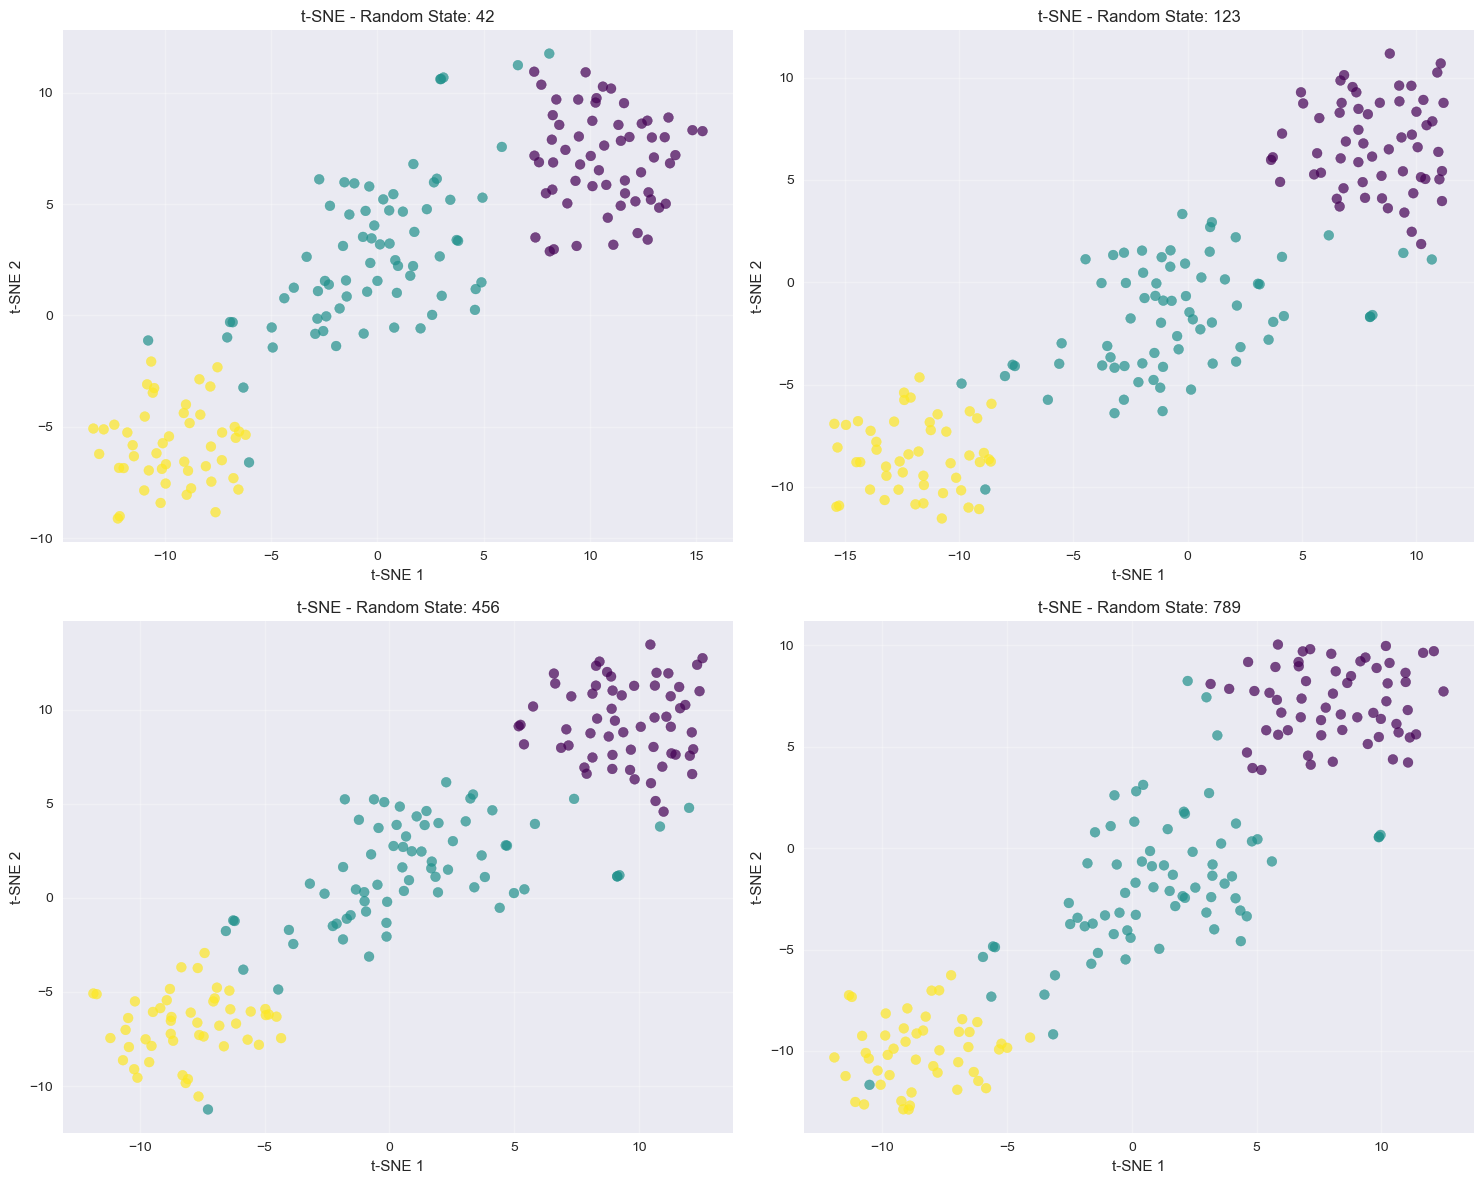

In [ ]:
random_states = [42, 123, 456, 789]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, random_state in enumerate(random_states):
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=random_state)
    wine_tsne_variation = tsne.fit_transform(wine_scaled)
    
    scatter = axes[i].scatter(wine_tsne_variation[:, 0], wine_tsne_variation[:, 1], 
                             c=wine[target], cmap='viridis', s=50, alpha=0.7)
    axes[i].set_title(f't-SNE - Random State: {random_state}')
    axes[i].set_xlabel('t-SNE 1')
    axes[i].set_ylabel('t-SNE 2')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Mirando los resultados, se puede notar que t-SNE supera a PCA para separar nuestras variedades de vino. Donde PCA mostraba mezcla y solapamiento, t-SNE logra una división clara(no perfecta, pero altamente significativa) de los tres tipos, cada uno en su espacio definido(excepto unos casos puntuales).

Al ver el efecto de perplexity, podemos ver que si es muy bajo se tiene que los grupos se fragmentan, mientras que si es muy alto se diluyen. Encontramos que entre 30-50 es el punto justo donde se mantiene la estructura natural. La diferencia es tan marcada que recomes recomendable adoptar t-SNE para el análisis de variedades.



### 3. **Comparación entre PCA y t-SNE**

* Contrastar las visualizaciones y discutir las **ventajas y limitaciones** de cada técnica:

  * PCA como método **lineal** para interpretar varianza y relaciones globales.
  * t-SNE como método **no lineal** que preserva relaciones locales y vecindades.
* Evaluar en qué escenarios prácticos sería más recomendable usar PCA (interpretabilidad, reducción previa para modelos) o t-SNE (exploración y visualización de clústeres).
* Reflexionar sobre la **importancia de la reducción de dimensionalidad** en datasets de alta dimensión como Wine, destacando su utilidad para:

  * Visualizar patrones ocultos en los datos.
  * Reducir complejidad y ruido antes de aplicar algoritmos de aprendizaje automático.
  * Facilitar la interpretación y comunicación de resultados.



**Respuesta**

La elección entre PCA y t-SNE depende completamente del objetivo del análisis. PCA funciona mejor cuando necesitamos entender qué variables impulsan las diferencias entre los vinos - su naturaleza lineal y los loadings nos dan esa transparencia interpretativa.

t-SNE, en cambio, es nuestro aliado para visualización y exploración. Donde PCA mostraba mezcla, t-SNE revela agrupaciones naturales bien definidas. 

De lo anterior, decimos que para análisis técnico y preprocesamiento de modelos predictivos es preferible optar por PCA dada su alta interpretabilidad. Mientras que para la exploración de datos, sacrificar interpretabilidad por precisión del modelo, es preferible optar por t-SNE.

La reducción dimensional es una herramienta estratégica que transforma datos complejos en relaciones comprensibles y accionables, preservando las relaciones esenciales y exhibiendo mapas simples pero efectivos.